<a href="https://colab.research.google.com/github/Nawel-Bellil/ENERGY-EFFICIENCY-MONITORING-SECURITY-IN-ATM-SITRE/blob/main/NESTHACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Read the original CSV file for BMC data
# Skip the first 3 rows and read the next 1290 rows
dBMC = pd.read_csv('BMC.csv', skiprows=3, nrows=1290)

# Read the original CSV file for host data
# Skip the first 1308 rows and read the next 1718 rows
dhost = pd.read_csv('BMC.csv', skiprows=1308, nrows=1718)

# Drop columns from BMC dataset
# Keep only time, device_id, and sensor measurements
dBMC_reduced = dBMC.drop(columns=['result', 'table', 'Unnamed: 0', '_start', '_stop'])

# Drop columns from host dataset
# Keeping only essential performance metrics and dropping individual core metrics
columns_to_drop_host = ['result', 'table', 'Unnamed: 0', '_start', '_stop', '_measurement']

# Add core metrics to drop list (we'll keep aggregated metrics instead of individual cores)
for i in range(0, 128):
    columns_to_drop_host.append(f'core{i}')

# Drop the identified columns
dhost_reduced = dhost.drop(columns=columns_to_drop_host, errors='ignore')

# Save to new CSV files
dBMC_reduced.to_csv('BMCsensor_reduced.csv', index=False)
dhost_reduced.to_csv('host_reduced.csv', index=False)

# Display the headers of the new files
print("Header of the BMC sensor file after dropping columns:")
print(dBMC_reduced.head())

print("\nHeader of the host file after dropping columns:")
print(dhost_reduced.head())

# Display columns kept in each dataset
print("\nColumns kept in BMC dataset:")
print(dBMC_reduced.columns.tolist())

print("\nColumns kept in host dataset:")
print(dhost_reduced.columns.tolist())

# Load the reduced datasets
dfBMC = pd.read_csv('BMCsensor_reduced.csv')
dfhost = pd.read_csv('host_reduced.csv')

# Display dataset information
dfBMC.info()
dfhost.info()

Header of the BMC sensor file after dropping columns:
                  _time _measurement device_id  Chipset2_Temp  Chipset_Temp  \
0  2024-11-01T10:01:08Z         sdgp       bmc           53.0          49.5   
1  2024-11-01T10:01:20Z         sdgp       bmc           53.0          49.0   
2  2024-11-01T10:01:30Z         sdgp       bmc           53.0          49.0   
3  2024-11-01T10:01:41Z         sdgp       bmc           53.0          49.5   
4  2024-11-01T10:01:53Z         sdgp       bmc           53.0          49.0   

   Cpu1_Temp  Cpu2_Temp  FAN1  FAN2  FAN3  ...  PSU1_CIN  PSU1_FAN  \
0       49.0       43.5  1706  1702  1682  ...      0.53      6264   
1       48.5       43.5  1674  1692  1701  ...      0.53      6264   
2       48.5       43.5  1695  1684  1698  ...      0.53      6264   
3       48.5       43.5  1696  1692  1691  ...      0.53      6264   
4       48.5       43.5  1701  1684  1697  ...      0.52      6264   

   PSU1_Inlet  PSU1_Total_Power  PSU1_VIN  PSU2_CI

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set display options to see more columns
pd.set_option('display.max_columns', None)

# Load the reduced datasets
print("Loading datasets...")
dfBMC = pd.read_csv('BMCsensor_reduced.csv')
dfhost = pd.read_csv('host_reduced.csv')

# Display initial information
print("\nInitial BMC dataset info:")
print(dfBMC.info())
print("\nBMC dataset sample:")
print(dfBMC.head())

print("\nInitial host dataset info:")
print(dfhost.info())
print("\nHost dataset sample:")
print(dfhost.head())

# ===== 1. IMPROVED TIME CONVERSION =====
print("\n=== Converting time columns to datetime ===")

# Function to convert time columns consistently with better handling for various formats
def convert_time_column(df, time_col='_time'):
    if time_col in df.columns:
        # Check current format
        print(f"Sample time value before conversion: {df[time_col].iloc[0]}")
        print(f"Current time column type: {df[time_col].dtype}")

        # Make a copy of original values to preserve them
        original_times = df[time_col].copy()

        # Convert to string first to handle any format issues
        df[time_col] = df[time_col].astype(str)

        # Method 1: Handle UTC 'Z' suffix explicitly
        temp_times = df[time_col].str.replace('Z', '')
        converted = pd.to_datetime(temp_times, errors='coerce')

        # Check if we got good conversions
        if converted.notna().sum() > 0:
            df[time_col] = converted
            print(f"Successfully converted using Method 1 (Z suffix removal)")
        else:
            # Method 2: Try with format specification
            converted = pd.to_datetime(df[time_col], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
            if converted.notna().sum() > 0:
                df[time_col] = converted
                print(f"Successfully converted using Method 2 (format specification)")
            else:
                # Method 3: Most permissive approach
                converted = pd.to_datetime(df[time_col], infer_datetime_format=True, errors='coerce')
                if converted.notna().sum() > 0:
                    df[time_col] = converted
                    print(f"Successfully converted using Method 3 (infer_datetime_format)")
                else:
                    # If all methods fail, keep original strings but warn
                    print("All conversion methods failed! Keeping original values.")
                    df[time_col] = original_times

        # Report on results
        invalid_count = df[time_col].isna().sum()
        if invalid_count > 0:
            print(f"  Warning: {invalid_count} timestamps couldn't be converted ({invalid_count/len(df)*100:.1f}%)")
            if invalid_count < len(df):
                # Show examples of successful and failed conversions
                good_example = df.loc[df[time_col].notna(), time_col].iloc[0] if df[time_col].notna().any() else "None"
                bad_idx = df[time_col].isna().idxmax() if df[time_col].isna().any() else None
                bad_example = original_times.loc[bad_idx] if bad_idx is not None else "None"
                print(f"  Successful conversion example: {good_example}")
                print(f"  Failed conversion example: {bad_example}")
        else:
            print(f"  All {len(df)} timestamps successfully converted")

        print(f"Sample time value after conversion: {df[time_col].iloc[0]}")
        print(f"New time column type: {df[time_col].dtype}")
    else:
        print(f"Time column '{time_col}' not found")

    return df

# Convert time columns in both datasets
dfBMC = convert_time_column(dfBMC)
dfhost = convert_time_column(dfhost)

# ===== 2. IMPROVED TYPE CONVERSION FOR NUMERIC COLUMNS =====
print("\n=== Converting string columns to numeric ===")

# Function to convert string columns to numeric with better error handling
def convert_string_to_numeric(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id']

    # Find string columns that aren't in the exclude list
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    string_cols = [col for col in string_cols if col not in exclude_cols]

    if not string_cols:
        print(f"No string columns found that need conversion")
        return df, {}

    print(f"Converting {len(string_cols)} string columns to numeric")
    conversion_report = {}

    for col in string_cols:
        # Skip empty columns
        if df[col].isna().all():
            print(f"  Skipping '{col}' - all values are NaN")
            continue

        # Save original values for comparison
        original_sample = df[col].head(2).tolist()
        original_dtype = df[col].dtype

        # Try to convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Report conversion results
        na_count = df[col].isna().sum()
        na_pct = na_count / len(df) * 100 if len(df) > 0 else 0

        conversion_report[col] = {
            'original_dtype': original_dtype,
            'new_dtype': df[col].dtype,
            'original_sample': original_sample,
            'converted_sample': df[col].head(2).tolist(),
            'na_count': na_count,
            'na_percent': na_pct
        }

        print(f"  Converted '{col}': {original_sample} -> {df[col].head(2).tolist()}")
        if na_count > 0:
            print(f"    Warning: {na_count} values ({na_pct:.1f}%) couldn't be converted to numeric")

            # If more than 50% failed, consider it might not be a numeric column
            if na_pct > 50:
                print(f"    High failure rate for '{col}' - might not be a numeric column")

    return df, conversion_report

# Convert string columns in both datasets
dfBMC, bmc_conv_report = convert_string_to_numeric(dfBMC)
dfhost, host_conv_report = convert_string_to_numeric(dfhost)

# ===== 3. IMPROVED MISSING VALUE HANDLING =====
print("\n=== Handling missing values with improved approach ===")

# Function to handle missing values with more sophisticated methods
def handle_missing_values(df, time_col='_time', strategy='mixed'):
    missing_counts = df.isna().sum()
    cols_with_missing = missing_counts[missing_counts > 0]

    if len(cols_with_missing) == 0:
        print("No missing values found")
        return df

    print(f"Found {len(cols_with_missing)} columns with missing values:")
    for col, count in cols_with_missing.items():
        pct_missing = count / len(df) * 100
        print(f"  {col}: {count} missing values ({pct_missing:.2f}%)")

        # Skip time column - we've already handled it
        if col == time_col:
            continue

        # For columns with extremely high missing value percentage, consider dropping
        if pct_missing > 75:
            print(f"  Warning: {col} has {pct_missing:.2f}% missing values - consider dropping")

        # Apply selected imputation strategy
        if strategy == 'mixed':
            # For categorical columns (object type)
            if df[col].dtype == 'object':
                mode_val = df[col].mode()[0] if not df[col].mode().empty else "UNKNOWN"
                df[col] = df[col].fillna(mode_val)
                print(f"  Filled '{col}' missing values with mode: {mode_val}")

            # For numeric columns, use more context-aware methods
            else:
                # If time-series data, consider forward/backward fill for temporal consistency
                if '_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df[time_col]):
                    # Sort by time first
                    df = df.sort_values(by=time_col)

                    # Try forward fill first, then backward fill for any remaining NAs
                    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
                    remaining = df[col].isna().sum()

                    # If we still have NAs, use median
                    if remaining > 0:
                        df[col] = df[col].fillna(df[col].median())
                        print(f"  Filled '{col}' using time-based methods + median for {remaining} values")
                    else:
                        print(f"  Filled '{col}' using time-based methods (ffill/bfill)")
                else:
                    # Without time context, use median
                    if df[col].count() > 0:  # Ensure we have some non-NaN values
                        df[col] = df[col].fillna(df[col].median())
                        print(f"  Filled '{col}' with median: {df[col].median()}")
                    else:
                        print(f"  Warning: '{col}' has all NaN values, filling with 0")
                        df[col] = df[col].fillna(0)

        elif strategy == 'median':
            if df[col].dtype != 'object':
                if df[col].count() > 0:
                    df[col] = df[col].fillna(df[col].median())
                    print(f"  Filled '{col}' with median: {df[col].median()}")
                else:
                    df[col] = df[col].fillna(0)
                    print(f"  Filled '{col}' with 0 (all values were NaN)")
            else:
                mode_val = df[col].mode()[0] if not df[col].mode().empty else "UNKNOWN"
                df[col] = df[col].fillna(mode_val)
                print(f"  Filled '{col}' with mode: {mode_val}")

    return df

# Apply improved missing value handling to both datasets
dfBMC = handle_missing_values(dfBMC, strategy='mixed')
dfhost = handle_missing_values(dfhost, strategy='mixed')

# ===== 4. OUTLIER DETECTION AND HANDLING =====
print("\n=== Detecting and handling outliers ===")

# Function to detect and handle outliers
def handle_outliers(df, exclude_cols=None, method='zscore', threshold=3):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id']

    # Only process numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    if not numeric_cols:
        print("No numeric columns found for outlier detection")
        return df, {}

    outlier_stats = {}
    print(f"Checking {len(numeric_cols)} numeric columns for outliers")

    for col in numeric_cols:
        # Skip columns with no variance
        if df[col].std() == 0:
            print(f"  Skipping '{col}' - zero variance")
            continue

        if method == 'zscore':
            # Z-score method: values beyond +/- threshold standard deviations
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            outliers = z_scores > threshold
            outlier_count = outliers.sum()

            if outlier_count > 0:
                outlier_pct = outlier_count / len(df) * 100
                outlier_stats[col] = {
                    'count': outlier_count,
                    'percentage': outlier_pct,
                    'min': df.loc[outliers, col].min(),
                    'max': df.loc[outliers, col].max()
                }

                print(f"  Detected {outlier_count} outliers ({outlier_pct:.2f}%) in '{col}' using Z-score > {threshold}")

                # Only cap outliers if they're not too prevalent (< 10%)
                if outlier_pct < 10:
                    # Cap the outliers instead of removing
                    lower_bound = df[col].mean() - threshold * df[col].std()
                    upper_bound = df[col].mean() + threshold * df[col].std()

                    # Store original values before capping
                    original_min = df[col].min()
                    original_max = df[col].max()

                    # Cap outliers
                    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

                    print(f"    Capped values from [{original_min}, {original_max}] to [{df[col].min()}, {df[col].max()}]")
                else:
                    print(f"    Warning: Not capping outliers in '{col}' as they represent {outlier_pct:.2f}% of the data")

        elif method == 'iqr':
            # IQR method: values beyond 1.5*IQR from Q1/Q3
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            if IQR == 0:
                print(f"  Skipping '{col}' - IQR is zero")
                continue

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            outlier_count = outliers.sum()

            if outlier_count > 0:
                outlier_pct = outlier_count / len(df) * 100
                outlier_stats[col] = {
                    'count': outlier_count,
                    'percentage': outlier_pct,
                    'min': df.loc[outliers, col].min(),
                    'max': df.loc[outliers, col].max(),
                    'bounds': [lower_bound, upper_bound]
                }

                print(f"  Detected {outlier_count} outliers ({outlier_pct:.2f}%) in '{col}' using IQR method")

                # Only cap outliers if they're not too prevalent (< 10%)
                if outlier_pct < 10:
                    # Store original values before capping
                    original_min = df[col].min()
                    original_max = df[col].max()

                    # Cap outliers
                    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

                    print(f"    Capped values from [{original_min}, {original_max}] to [{df[col].min()}, {df[col].max()}]")
                else:
                    print(f"    Warning: Not capping outliers in '{col}' as they represent {outlier_pct:.2f}% of the data")

    return df, outlier_stats

# Apply outlier handling to both datasets
dfBMC, bmc_outlier_stats = handle_outliers(dfBMC, method='iqr')
dfhost, host_outlier_stats = handle_outliers(dfhost, method='iqr')

# ===== 5. FEATURE SELECTION BASED ON VARIANCE AND CORRELATION =====
print("\n=== Feature selection based on variance and correlation ===")

# Function to select features based on variance and correlation
def select_features(df, exclude_cols=None, variance_threshold=0.01, correlation_threshold=0.95):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id']

    # Only analyze numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    if not numeric_cols:
        print("No numeric columns found for feature selection")
        return {'low_variance': [], 'high_correlation': []}

    # Check for low variance features
    variance = df[numeric_cols].var()
    low_var_features = variance[variance < variance_threshold].index.tolist()

    if low_var_features:
        print(f"Low variance features (< {variance_threshold}):")
        for feature in low_var_features:
            print(f"  {feature}: variance = {variance[feature]:.6f}")
    else:
        print(f"No low variance features found (threshold: {variance_threshold})")

    # Check for highly correlated features
    try:
        correlation_matrix = df[numeric_cols].corr().abs()

        # Create a mask for the upper triangle
        upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

        # Find features with correlation greater than threshold
        high_corr_features = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

        if high_corr_features:
            print(f"\nHighly correlated features (> {correlation_threshold}):")
            for column in high_corr_features:
                correlated_with = upper[column][upper[column] > correlation_threshold].index.tolist()
                for other_col in correlated_with:
                    corr_value = correlation_matrix.loc[column, other_col]
                    print(f"  {column} and {other_col}: correlation = {corr_value:.4f}")
        else:
            print(f"No highly correlated features found (threshold: {correlation_threshold})")

    except Exception as e:
        print(f"Error during correlation analysis: {e}")
        high_corr_features = []

    # Return list of features to drop
    return {
        'low_variance': low_var_features,
        'high_correlation': high_corr_features
    }

# Apply feature selection to both datasets
bmc_feature_selection = select_features(dfBMC)
host_feature_selection = select_features(dfhost)

# ===== 6. SAVE PROCESSED DATASETS =====
print("\n=== Saving processed datasets ===")

# Save the fully processed datasets
dfBMC.to_csv('BMC_processed.csv', index=False)
dfhost.to_csv('host_processed.csv', index=False)

print("\nProcessing complete. Datasets saved as BMC_processed.csv and host_processed.csv")

# ===== 7. DATASET SUMMARY =====
print("\n=== Final Dataset Summary ===")
print(f"BMC dataset: {dfBMC.shape[0]} rows, {dfBMC.shape[1]} columns")
print(f"Host dataset: {dfhost.shape[0]} rows, {dfhost.shape[1]} columns")

print("\nBMC Columns:")
for col in dfBMC.columns:
    print(f"  {col} ({dfBMC[col].dtype})")

print("\nHost Columns:")
for col in dfhost.columns:
    print(f"  {col} ({dfhost[col].dtype})")

# Create visual summary of the data if available
try:
    # Plot a correlation heatmap for BMC data
    plt.figure(figsize=(14, 12))
    numeric_cols = dfBMC.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 1:  # Need at least 2 columns for correlation
        sns.heatmap(dfBMC[numeric_cols].corr(), annot=False, cmap='coolwarm')
        plt.title('Correlation Heatmap - BMC Data')
        plt.tight_layout()
        plt.savefig('bmc_correlation_heatmap.png')
        plt.close()
        print("\nSaved BMC correlation heatmap as bmc_correlation_heatmap.png")

    # Plot a correlation heatmap for host data
    plt.figure(figsize=(14, 12))
    numeric_cols = dfhost.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 1:  # Need at least 2 columns for correlation
        sns.heatmap(dfhost[numeric_cols].corr(), annot=False, cmap='coolwarm')
        plt.title('Correlation Heatmap - Host Data')
        plt.tight_layout()
        plt.savefig('host_correlation_heatmap.png')
        plt.close()
        print("Saved host correlation heatmap as host_correlation_heatmap.png")
except Exception as e:
    print(f"Error creating correlation heatmaps: {e}")

Loading datasets...

Initial BMC dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _time             1290 non-null   object 
 1   _measurement      1290 non-null   object 
 2   device_id         1290 non-null   object 
 3   Chipset2_Temp     1290 non-null   float64
 4   Chipset_Temp      1290 non-null   float64
 5   Cpu1_Temp         1290 non-null   float64
 6   Cpu2_Temp         1290 non-null   float64
 7   FAN1              1290 non-null   int64  
 8   FAN2              1290 non-null   int64  
 9   FAN3              1290 non-null   int64  
 10  FAN4              1290 non-null   int64  
 11  IO_Outlet_Temp    1290 non-null   float64
 12  Inlet_Temp        1290 non-null   float64
 13  Outlet_Temp       1290 non-null   float64
 14  PSU1_CIN          1290 non-null   float64
 15  PSU1_FAN          1290 non-null   int64  


<ipython-input-2-2ec1480bad37>:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


  Detected 232 outliers (13.50%) in 'temp1' using IQR method
  Detected 152 outliers (8.85%) in 'temp2' using IQR method
    Capped values from [54.2, 60.9] to [55.349999999999994, 60.55000000000001]
  Detected 210 outliers (12.22%) in 'temp3' using IQR method
  Detected 157 outliers (9.14%) in 'temp4' using IQR method
    Capped values from [54.3, 60.6] to [55.44999999999999, 60.6]
  Detected 179 outliers (10.42%) in 'temp5' using IQR method
  Detected 89 outliers (5.18%) in 'temp6' using IQR method
    Capped values from [54.3, 60.9] to [55.3, 60.89999999999999]
  Detected 229 outliers (13.33%) in 'temp7' using IQR method
  Detected 65 outliers (3.78%) in 'temp8' using IQR method
    Capped values from [54.9, 61.6] to [55.65, 61.6]
  Skipping 'temp9' - IQR is zero
  Skipping 'total_vcpu' - IQR is zero
  Skipping 'total_vm' - IQR is zero

=== Feature selection based on variance and correlation ===
Low variance features (< 0.01):
  PSU1_CIN: variance = 0.000176
  PSU2_CIN: variance = 0

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed datasets
print("Loading processed datasets...")
dfBMC = pd.read_csv('BMC_processed.csv')
dfhost = pd.read_csv('host_processed.csv')

# Ensure time columns are datetime
dfBMC['_time'] = pd.to_datetime(dfBMC['_time'])
dfhost['_time'] = pd.to_datetime(dfhost['_time'])

# ===== 1. TEMPORAL FEATURE EXTRACTION =====
print("\n=== Creating temporal features ===")

# Function to create time-based features
def create_temporal_features(df):
    # Ensure we're working with datetime
    if '_time' not in df.columns:
        print("Error: No time column found")
        return df

    # Make sure the time column is datetime
    df['_time'] = pd.to_datetime(df['_time'])

    # Extract basic time components
    df['hour'] = df['_time'].dt.hour
    df['day'] = df['_time'].dt.day
    df['weekday'] = df['_time'].dt.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Sort by time to ensure proper sequence
    df = df.sort_values('_time')

    # Add a row identifier for sequential operations
    df['row_id'] = range(len(df))

    # Create time difference features (how much time has passed since the last reading)
    df['time_diff'] = df['_time'].diff().dt.total_seconds().fillna(0)

    print(f"Created temporal features: hour, day, weekday, is_weekend, time_diff")

    return df

# Apply temporal feature creation to both datasets
dfBMC = create_temporal_features(dfBMC)
dfhost = create_temporal_features(dfhost)

# ===== 2. ROLLING WINDOW STATISTICS =====
print("\n=== Creating rolling window features ===")

# Function to create rolling window features for numeric columns
def create_rolling_features(df, window_sizes=[5, 10], exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id', 'hour', 'day', 'weekday', 'is_weekend', 'row_id', 'time_diff']

    # Ensure data is sorted by time
    df = df.sort_values('_time')

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Generate rolling window features for each numeric column
    for col in numeric_cols:
        for window in window_sizes:
            # Create rolling mean
            df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()

            # Create rolling std
            df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()

            # Create z-score relative to rolling window (how many std deviations from rolling mean)
            mean_col = f'{col}_roll_mean_{window}'
            std_col = f'{col}_roll_std_{window}'
            df[f'{col}_zscore_{window}'] = (df[col] - df[mean_col]) / df[std_col].replace(0, 1)  # Avoid div by zero

        print(f"Created rolling features for {col} with windows {window_sizes}")

    return df

# Create rolling features for key metrics
# Select only the most important columns to avoid feature explosion
bmc_key_metrics = [
    'Cpu1_Temp', 'Cpu2_Temp', 'FAN1', 'FAN2', 'FAN3', 'FAN4',
    'PSU1_Total_Power', 'PSU2_Total_Power'
]

host_key_metrics = [
    'cpu_usage', 'mem_usage', 'load_1', 'load_5', 'load_15',
    'cache_misses', 'L1_dcache_load_misses'
]

# Apply rolling features to selected columns
for col in bmc_key_metrics:
    if col in dfBMC.columns:
        # Create features for just this column
        exclude_cols = ['_time', 'device_id', 'hour', 'day', 'weekday', 'is_weekend', 'row_id', 'time_diff']
        temp_cols = [c for c in dfBMC.columns if c != col and c not in exclude_cols]
        exclude_cols.extend(temp_cols)

        dfBMC = create_rolling_features(dfBMC, window_sizes=[5, 10], exclude_cols=exclude_cols)

for col in host_key_metrics:
    if col in dfhost.columns:
        # Create features for just this column
        exclude_cols = ['_time', 'device_id', 'hour', 'day', 'weekday', 'is_weekend', 'row_id', 'time_diff']
        temp_cols = [c for c in dfhost.columns if c != col and c not in exclude_cols]
        exclude_cols.extend(temp_cols)

        dfhost = create_rolling_features(dfhost, window_sizes=[5, 10], exclude_cols=exclude_cols)

# ===== 3. RATE OF CHANGE FEATURES =====
print("\n=== Creating rate of change features ===")

# Function to create rate of change features
def create_rate_of_change(df, metrics, periods=[1, 3]):
    for col in metrics:
        if col in df.columns:
            for period in periods:
                # Percentage change
                df[f'{col}_pct_change_{period}'] = df[col].pct_change(periods=period).fillna(0)

                # Absolute diff (can be useful when the value can be negative)
                df[f'{col}_diff_{period}'] = df[col].diff(periods=period).fillna(0)

            print(f"Created rate of change features for {col}")

    return df

# Apply rate of change to key metrics
dfBMC = create_rate_of_change(dfBMC, bmc_key_metrics)
dfhost = create_rate_of_change(dfhost, host_key_metrics)

# ===== 4. DATA SCALING =====
print("\n=== Scaling features ===")

# Function to scale numeric features
def scale_features(df, scaler_type='standard', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id', 'hour', 'day', 'weekday', 'is_weekend', 'row_id']

    # Select numeric columns for scaling
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Create a copy of the dataframe for scaled values
    df_scaled = df.copy()

    # Initialize the appropriate scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")

    # Fit and transform the selected columns
    if numeric_cols:
        df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        print(f"Scaled {len(numeric_cols)} numeric columns using {scaler_type} scaling")
    else:
        print("No numeric columns found for scaling")

    return df_scaled, scaler

# Scale features in both datasets
dfBMC_scaled, bmc_scaler = scale_features(dfBMC)
dfhost_scaled, host_scaler = scale_features(dfhost)

# ===== 5. FEATURE CORRELATION ANALYSIS =====
print("\n=== Analyzing feature correlations ===")

# Function to find and visualize highly correlated features
def analyze_correlations(df, threshold=0.9, exclude_cols=None, title="Feature Correlation Analysis"):
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id', 'row_id']

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Calculate correlation matrix
    corr = df[numeric_cols].corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Find highly correlated pairs
    pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) >= threshold:
                pairs.append({
                    'feature1': corr.columns[i],
                    'feature2': corr.columns[j],
                    'correlation': corr.iloc[i, j]
                })

    # Sort by absolute correlation (highest first)
    pairs = sorted(pairs, key=lambda x: abs(x['correlation']), reverse=True)

    # Print top highly correlated pairs
    print(f"\nHighly correlated features (|correlation| >= {threshold}):")
    for pair in pairs[:10]:  # Show top 10
        print(f"  {pair['feature1']} & {pair['feature2']}: {pair['correlation']:.4f}")

    # Return pairs for further processing
    return pairs

# Analyze correlations in both datasets
bmc_correlations = analyze_correlations(dfBMC_scaled, title="BMC Feature Correlations")
host_correlations = analyze_correlations(dfhost_scaled, title="Host Feature Correlations")

# ===== 6. MERGE DATASETS (OPTIONAL) =====
print("\n=== Merging datasets (optional) ===")

# Function to merge BMC and host datasets on time
def merge_datasets(df_bmc, df_host, time_tolerance=pd.Timedelta(minutes=1)):
    # Ensure time columns are datetime
    df_bmc['_time'] = pd.to_datetime(df_bmc['_time'])
    df_host['_time'] = pd.to_datetime(df_host['_time'])

    # Get list of columns with same name in both datasets (aside from _time and device_id)
    common_cols = set(df_bmc.columns) & set(df_host.columns) - {'_time', 'device_id'}

    if common_cols:
        print(f"Found common columns in both datasets: {common_cols}")
        # Rename common columns in the host dataset to avoid conflicts
        rename_dict = {col: f'host_{col}' for col in common_cols}
        df_host = df_host.rename(columns=rename_dict)

    # Option 1: Merge on exact timestamp (if available)
    if len(set(df_bmc['_time']) & set(df_host['_time'])) > 0:
        print("Merging on exact timestamps")
        merged_df = pd.merge(df_bmc, df_host, on='_time', suffixes=('_bmc', '_host'))

    # Option 2: Use nearest time approach
    else:
        print(f"Using nearest time merge with tolerance {time_tolerance}")
        # Sort both dataframes by time
        df_bmc = df_bmc.sort_values('_time')
        df_host = df_host.sort_values('_time')

        # Create a list to store merged rows
        merged_rows = []

        # For each row in BMC, find the closest host row
        for _, bmc_row in df_bmc.iterrows():
            bmc_time = bmc_row['_time']

            # Find closest host row within tolerance
            time_diffs = (df_host['_time'] - bmc_time).abs()
            closest_idx = time_diffs.idxmin()

            if time_diffs[closest_idx] <= time_tolerance:
                host_row = df_host.loc[closest_idx]

                # Combine the rows
                merged_row = {**bmc_row.to_dict(), **host_row.to_dict()}
                # Fix the _time (use BMC time)
                merged_row['_time'] = bmc_time
                # Rename device_id from host
                if 'device_id' in host_row:
                    merged_row['device_id_host'] = host_row['device_id']

                merged_rows.append(merged_row)

        if merged_rows:
            merged_df = pd.DataFrame(merged_rows)
        else:
            print("Warning: No matching rows found within the specified time tolerance")
            merged_df = None

    if merged_df is not None:
        print(f"Successfully merged datasets: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")

    return merged_df

# Try to merge datasets (if they have overlapping time periods)
try:
    merged_df = merge_datasets(dfBMC, dfhost)

    if merged_df is not None:
        # Save merged dataset
        merged_df.to_csv('merged_dataset.csv', index=False)
        print("Saved merged dataset to merged_dataset.csv")
except Exception as e:
    print(f"Error merging datasets: {e}")
    print("Continuing with separate datasets for analysis")
    merged_df = None

# ===== 7. SAVE ENGINEERED DATASETS =====
print("\n=== Saving engineered datasets ===")

# Save the engineered datasets
dfBMC_scaled.to_csv('BMC_engineered.csv', index=False)
dfhost_scaled.to_csv('host_engineered.csv', index=False)

print("\nFeature engineering complete.")
print(f"BMC dataset: {dfBMC_scaled.shape[0]} rows, {dfBMC_scaled.shape[1]} columns")
print(f"Host dataset: {dfhost_scaled.shape[0]} rows, {dfhost_scaled.shape[1]} columns")
if merged_df is not None:
    print(f"Merged dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")

# Display feature counts by category
bmc_feature_counts = {
    'Original': len(set(dfBMC.columns) - set(['hour', 'day', 'weekday', 'is_weekend', 'row_id', 'time_diff'])),
    'Temporal': 5,  # hour, day, weekday, is_weekend, time_diff
    'Rolling': sum(1 for col in dfBMC_scaled.columns if ('roll_mean' in col or 'roll_std' in col or 'zscore' in col)),
    'Rate of Change': sum(1 for col in dfBMC_scaled.columns if ('pct_change' in col or '_diff_' in col)),
    'Total': dfBMC_scaled.shape[1]
}

host_feature_counts = {
    'Original': len(set(dfhost.columns) - set(['hour', 'day', 'weekday', 'is_weekend', 'row_id', 'time_diff'])),
    'Temporal': 5,  # hour, day, weekday, is_weekend, time_diff
    'Rolling': sum(1 for col in dfhost_scaled.columns if ('roll_mean' in col or 'roll_std' in col or 'zscore' in col)),
    'Rate of Change': sum(1 for col in dfhost_scaled.columns if ('pct_change' in col or '_diff_' in col)),
    'Total': dfhost_scaled.shape[1]
}

print("\nBMC Feature Counts:")
for category, count in bmc_feature_counts.items():
    print(f"  {category}: {count}")

print("\nHost Feature Counts:")
for category, count in host_feature_counts.items():
    print(f"  {category}: {count}")

Loading processed datasets...

=== Creating temporal features ===
Created temporal features: hour, day, weekday, is_weekend, time_diff
Created temporal features: hour, day, weekday, is_weekend, time_diff

=== Creating rolling window features ===
Created rolling features for Cpu1_Temp with windows [5, 10]
Created rolling features for Cpu2_Temp with windows [5, 10]
Created rolling features for FAN1 with windows [5, 10]
Created rolling features for FAN2 with windows [5, 10]
Created rolling features for FAN3 with windows [5, 10]
Created rolling features for FAN4 with windows [5, 10]
Created rolling features for PSU1_Total_Power with windows [5, 10]
Created rolling features for PSU2_Total_Power with windows [5, 10]
Created rolling features for cpu_usage with windows [5, 10]
Created rolling features for mem_usage with windows [5, 10]
Created rolling features for load_1 with windows [5, 10]
Created rolling features for load_5 with windows [5, 10]
Created rolling features for load_15 with wind

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Highly correlated features (|correlation| >= 0.9):
  FAN3_pct_change_1 & FAN3_diff_1: 1.0000
  FAN2_pct_change_1 & FAN2_diff_1: 1.0000
  FAN3_pct_change_3 & FAN3_diff_3: 1.0000
  FAN2_pct_change_3 & FAN2_diff_3: 1.0000
  FAN4_pct_change_1 & FAN4_diff_1: 1.0000
  FAN4_pct_change_3 & FAN4_diff_3: 1.0000
  FAN1_pct_change_3 & FAN1_diff_3: 1.0000
  FAN1_pct_change_1 & FAN1_diff_1: 1.0000
  Cpu2_Temp_pct_change_1 & Cpu2_Temp_diff_1: 0.9999
  Cpu2_Temp_pct_change_3 & Cpu2_Temp_diff_3: 0.9999

Highly correlated features (|correlation| >= 0.9):
  total_vcpu & total_vm: 1.0000
  mem_usage_pct_change_1 & mem_usage_diff_1: 1.0000
  mem_usage_pct_change_3 & mem_usage_diff_3: 1.0000
  kvm_entry & kvm_exit: 1.0000
  load_15 & load_15_roll_mean_5: 1.0000
  load_15_roll_mean_5 & load_15_roll_mean_10: 0.9999
  load_15 & load_15_roll_mean_10: 0.9998
  load_5 & load_5_roll_mean_5: 0.9998
  load_5_roll_mean_5 & load_5_roll_mean_10: 0.9997
  load_5 & load_5_roll_mean_10: 0.9992

=== Merging datasets (opti

Loading engineered datasets...
Loaded engineered datasets
Loaded merged dataset: 153 rows, 235 columns

=== Preparing data for modeling ===
Found 1322 NaN values across 107 features
  Column '_measurement' has 1290 NaNs (100.0%) - consider dropping
  Column '_measurement' has all NaN values - filling with 0
  Filled 1 NaNs in 'Cpu1_Temp_roll_std_5' with mean: 0.0000
  Filled 1 NaNs in 'Cpu1_Temp_zscore_5' with mean: -0.0000
  Filled 1 NaNs in 'Cpu1_Temp_roll_std_10' with mean: 0.0000
  Filled 1 NaNs in 'Cpu1_Temp_zscore_10' with mean: -0.0000
  Filled 1 NaNs in 'Cpu2_Temp_roll_std_5' with mean: 0.0000
  Filled 1 NaNs in 'Cpu2_Temp_zscore_5' with mean: -0.0000
  Filled 1 NaNs in 'Cpu2_Temp_roll_std_10' with mean: 0.0000
  Filled 1 NaNs in 'Cpu2_Temp_zscore_10' with mean: -0.0000
  Filled 1 NaNs in 'FAN1_roll_std_5' with mean: 0.0000
  Filled 1 NaNs in 'FAN1_zscore_5' with mean: 0.0000
  Filled 1 NaNs in 'FAN1_roll_std_10' with mean: 0.0000
  Filled 1 NaNs in 'FAN1_zscore_10' with mean: 

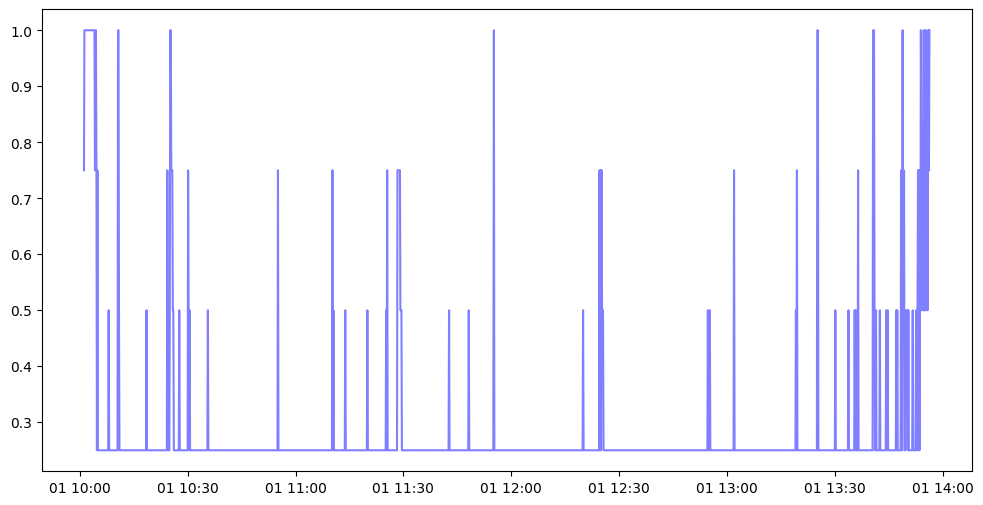

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# Load engineered datasets
print("Loading engineered datasets...")
try:
    # Try to load the datasets - adjust paths if needed
    dfBMC = pd.read_csv('BMC_engineered.csv')
    dfhost = pd.read_csv('host_engineered.csv')
    print("Loaded engineered datasets")

    # Also check if merged dataset exists
    try:
        merged_df = pd.read_csv('merged_dataset.csv')
        print(f"Loaded merged dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        use_merged = True
    except:
        print("No merged dataset found")
        use_merged = False
except:
    print("Engineered datasets not found, loading processed datasets...")
    try:
        dfBMC = pd.read_csv('BMC_processed.csv')
        dfhost = pd.read_csv('host_processed.csv')
        print("Loaded processed datasets")
        use_merged = False
    except:
        print("ERROR: Could not load datasets. Please run preprocessing first.")
        raise

# ===== 1. PREPARE DATA FOR MODELING - WITH IMPROVED NAN HANDLING =====
print("\n=== Preparing data for modeling ===")

def prepare_data_for_modeling(df, exclude_cols=None):
    """Prepare data for modeling with thorough NaN handling"""
    if exclude_cols is None:
        exclude_cols = ['_time', 'device_id', 'row_id']

    # Drop non-feature columns
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    # Ensure all columns are numeric
    X = df[feature_cols].select_dtypes(include=['number'])

    # Report on NaN values before handling
    nan_count_before = X.isna().sum().sum()
    if nan_count_before > 0:
        print(f"Found {nan_count_before} NaN values across {X.shape[1]} features")

    # Handle missing values by column
    for col in X.columns:
        nan_count = X[col].isna().sum()
        if nan_count > 0:
            # If many NaN values, consider dropping the column
            if nan_count / len(X) > 0.5:  # More than 50% missing
                print(f"  Column '{col}' has {nan_count} NaNs ({nan_count/len(X)*100:.1f}%) - consider dropping")

            # Fill missing values with column mean
            col_mean = X[col].mean()
            if pd.isna(col_mean):  # If mean is also NaN (all values are NaN)
                print(f"  Column '{col}' has all NaN values - filling with 0")
                X[col] = X[col].fillna(0)
            else:
                X[col] = X[col].fillna(col_mean)
                print(f"  Filled {nan_count} NaNs in '{col}' with mean: {col_mean:.4f}")

    # Verify no NaNs remain and report
    nan_count_after = X.isna().sum().sum()
    if nan_count_after > 0:
        print(f"WARNING: {nan_count_after} NaN values remain - replacing with 0")
        X = X.fillna(0)  # Last resort
    else:
        print(f"Successfully handled all NaN values. Dataset shape: {X.shape}")

    return X, X.columns.tolist()

# Prepare each dataset with improved NaN handling
X_bmc, bmc_features = prepare_data_for_modeling(dfBMC)
X_host, host_features = prepare_data_for_modeling(dfhost)

if use_merged:
    X_merged, merged_features = prepare_data_for_modeling(merged_df)

# ===== 2. ISOLATION FOREST MODEL =====
print("\n=== Isolation Forest Model ===")

def train_isolation_forest(X, df, contamination=0.05, n_estimators=100, random_state=42):
    """Train Isolation Forest with error handling"""
    try:
        if X.shape[0] < 10:
            print("Too few samples for Isolation Forest")
            return None, df, None, np.zeros(len(df))

        # Double check for NaNs
        if X.isna().sum().sum() > 0:
            print(f"WARNING: {X.isna().sum().sum()} NaN values detected. Filling with 0.")
            X = X.fillna(0)

        # Train model
        model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=random_state
        )

        # Fit and predict
        model.fit(X)
        scores = model.decision_function(X)
        predictions = model.predict(X)

        # Convert predictions to binary (1 = normal, -1 = anomaly)
        # Also convert to 0 = normal, 1 = anomaly for easier interpretation
        anomaly_labels = np.where(predictions == -1, 1, 0)

        # Add results to dataframe
        results_df = df.copy()
        results_df['anomaly_score'] = scores
        results_df['is_anomaly'] = anomaly_labels

        # Get anomaly statistics
        anomaly_count = np.sum(anomaly_labels)
        anomaly_percent = (anomaly_count / len(anomaly_labels)) * 100

        print(f"Isolation Forest detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")

        return model, results_df, scores, anomaly_labels
    except Exception as e:
        print(f"Error in Isolation Forest: {e}")
        return None, df, None, np.zeros(len(df))

# Train Isolation Forest on BMC dataset
iforest_bmc, results_bmc_if, scores_bmc_if, anomalies_bmc_if = train_isolation_forest(X_bmc, dfBMC)

# Train Isolation Forest on host dataset
iforest_host, results_host_if, scores_host_if, anomalies_host_if = train_isolation_forest(X_host, dfhost)

if use_merged:
    # Train Isolation Forest on merged dataset
    iforest_merged, results_merged_if, scores_merged_if, anomalies_merged_if = train_isolation_forest(X_merged, merged_df)

# ===== 3. ONE-CLASS SVM MODEL =====
print("\n=== One-Class SVM Model ===")

def train_ocsvm(X, df, nu=0.05, kernel='rbf'):
    """Train One-Class SVM with enhanced error handling"""
    try:
        if X.shape[0] < 10:
            print("Too few samples for One-Class SVM")
            return None, df, None, np.zeros(len(df))

        # Double check for NaNs
        if X.isna().sum().sum() > 0:
            print(f"WARNING: {X.isna().sum().sum()} NaN values detected. Filling with 0.")
            X = X.fillna(0)

        # Train model
        model = OneClassSVM(
            nu=nu,  # Similar to contamination
            kernel=kernel
        )

        # Fit and predict
        model.fit(X)
        predictions = model.predict(X)
        scores = model.decision_function(X)

        # Convert predictions to binary (1 = normal, -1 = anomaly)
        # Also convert to 0 = normal, 1 = anomaly for easier interpretation
        anomaly_labels = np.where(predictions == -1, 1, 0)

        # Add results to dataframe
        results_df = df.copy()
        results_df['anomaly_score'] = scores
        results_df['is_anomaly'] = anomaly_labels

        # Get anomaly statistics
        anomaly_count = np.sum(anomaly_labels)
        anomaly_percent = (anomaly_count / len(anomaly_labels)) * 100

        print(f"One-Class SVM detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")

        return model, results_df, scores, anomaly_labels
    except Exception as e:
        print(f"Error training One-Class SVM: {e}")
        return None, df, None, np.zeros(len(df))

# Train One-Class SVM on BMC dataset
ocsvm_bmc, results_bmc_ocsvm, scores_bmc_ocsvm, anomalies_bmc_ocsvm = train_ocsvm(X_bmc, dfBMC)

# Train One-Class SVM on host dataset
ocsvm_host, results_host_ocsvm, scores_host_ocsvm, anomalies_host_ocsvm = train_ocsvm(X_host, dfhost)

if use_merged:
    # Train One-Class SVM on merged dataset
    ocsvm_merged, results_merged_ocsvm, scores_merged_ocsvm, anomalies_merged_ocsvm = train_ocsvm(X_merged, merged_df)

# ===== 4. LOCAL OUTLIER FACTOR MODEL =====
print("\n=== Local Outlier Factor Model ===")

def train_lof(X, df, n_neighbors=20, contamination=0.05):
    """Train Local Outlier Factor with enhanced error handling"""
    try:
        # Handle small dataset
        if X.shape[0] < n_neighbors + 1:
            print(f"Warning: Sample size ({X.shape[0]}) too small for {n_neighbors} neighbors")
            n_neighbors = max(1, X.shape[0] // 2)
            print(f"Reducing to {n_neighbors} neighbors")

        # Double check for NaNs
        if X.isna().sum().sum() > 0:
            print(f"WARNING: {X.isna().sum().sum()} NaN values detected. Filling with 0.")
            X = X.fillna(0)

        # Train model
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True
        )

        # Fit and predict
        model.fit(X)
        scores = -model.decision_function(X)  # Negative because higher means more anomalous
        predictions = model.predict(X)

        # Convert predictions to binary (1 = normal, -1 = anomaly)
        # Also convert to 0 = normal, 1 = anomaly for easier interpretation
        anomaly_labels = np.where(predictions == -1, 1, 0)

        # Add results to dataframe
        results_df = df.copy()
        results_df['anomaly_score'] = scores
        results_df['is_anomaly'] = anomaly_labels

        # Get anomaly statistics
        anomaly_count = np.sum(anomaly_labels)
        anomaly_percent = (anomaly_count / len(anomaly_labels)) * 100

        print(f"Local Outlier Factor detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")

        return model, results_df, scores, anomaly_labels
    except Exception as e:
        print(f"Error in LOF: {e}")
        return None, df, None, np.zeros(len(df))

# Train LOF on BMC dataset
lof_bmc, results_bmc_lof, scores_bmc_lof, anomalies_bmc_lof = train_lof(X_bmc, dfBMC)

# Train LOF on host dataset
lof_host, results_host_lof, scores_host_lof, anomalies_host_lof = train_lof(X_host, dfhost)

if use_merged:
    # Train LOF on merged dataset
    lof_merged, results_merged_lof, scores_merged_lof, anomalies_merged_lof = train_lof(X_merged, merged_df)

# ===== 5. DBSCAN CLUSTERING MODEL =====
print("\n=== DBSCAN Clustering Model ===")

def train_dbscan(X, df, eps=0.5, min_samples=5):
    """Train DBSCAN with enhanced error handling"""
    try:
        # Handle small dataset
        if X.shape[0] < min_samples * 2:
            print(f"Warning: Sample size ({X.shape[0]}) too small for min_samples={min_samples}")
            min_samples = max(2, X.shape[0] // 5)
            print(f"Reducing to min_samples={min_samples}")

        # Double check for NaNs
        if X.isna().sum().sum() > 0:
            print(f"WARNING: {X.isna().sum().sum()} NaN values detected. Filling with 0.")
            X = X.fillna(0)

        # Train model
        model = DBSCAN(
            eps=eps,
            min_samples=min_samples
        )

        # Fit and predict
        clusters = model.fit_predict(X)

        # In DBSCAN, -1 cluster is noise/anomalies
        anomaly_labels = np.where(clusters == -1, 1, 0)

        # Calculate anomaly scores (distance to nearest core point)
        # This is a simplified version, as DBSCAN doesn't provide scores directly
        scores = np.zeros(len(X))
        for i, is_anomaly in enumerate(anomaly_labels):
            if is_anomaly:
                # For anomalies, use a high score
                scores[i] = 1.0
            else:
                # For normal points, score is 0
                scores[i] = 0.0

        # Add results to dataframe
        results_df = df.copy()
        results_df['cluster'] = clusters
        results_df['anomaly_score'] = scores
        results_df['is_anomaly'] = anomaly_labels

        # Get anomaly statistics
        anomaly_count = np.sum(anomaly_labels)
        anomaly_percent = (anomaly_count / len(anomaly_labels)) * 100

        print(f"DBSCAN detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")

        return model, results_df, scores, anomaly_labels
    except Exception as e:
        print(f"Error in DBSCAN: {e}")
        return None, df, None, np.zeros(len(df))

# Train DBSCAN on BMC dataset
dbscan_bmc, results_bmc_dbscan, scores_bmc_dbscan, anomalies_bmc_dbscan = train_dbscan(X_bmc, dfBMC)

# Train DBSCAN on host dataset
dbscan_host, results_host_dbscan, scores_host_dbscan, anomalies_host_dbscan = train_dbscan(X_host, dfhost)

if use_merged:
    # Train DBSCAN on merged dataset
    dbscan_merged, results_merged_dbscan, scores_merged_dbscan, anomalies_merged_dbscan = train_dbscan(X_merged, merged_df)

# ===== 6. ENSEMBLE MODEL (VOTING) =====
print("\n=== Ensemble Model (Voting) ===")

def create_ensemble(df, anomaly_predictions_list, threshold=0.5):
    """Create ensemble model with enhanced error handling"""
    try:
        # Validate input
        valid_predictions = []
        for i, pred in enumerate(anomaly_predictions_list):
            if pred is not None and len(pred) == len(df):
                valid_predictions.append(pred)

        if not valid_predictions:
            print("Error: No valid predictions for ensemble")
            return df, np.zeros(len(df)), np.zeros(len(df))

        # Create a matrix of all model predictions
        all_predictions = np.column_stack(valid_predictions)

        # Calculate the fraction of models that predict an anomaly
        ensemble_scores = np.mean(all_predictions, axis=1)

        # Apply threshold to get final prediction
        ensemble_predictions = np.where(ensemble_scores >= threshold, 1, 0)

        # Add results to dataframe
        results_df = df.copy()
        results_df['ensemble_score'] = ensemble_scores
        results_df['is_anomaly'] = ensemble_predictions

        # Get anomaly statistics
        anomaly_count = np.sum(ensemble_predictions)
        anomaly_percent = (anomaly_count / len(ensemble_predictions)) * 100

        print(f"Ensemble model detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")
        print(f"Used {len(valid_predictions)} models for ensemble voting")

        return results_df, ensemble_scores, ensemble_predictions
    except Exception as e:
        print(f"Error in ensemble creation: {e}")
        return df, np.zeros(len(df)), np.zeros(len(df))

# Create ensemble for BMC dataset
bmc_anomaly_predictions = []
if 'anomalies_bmc_if' in locals() and anomalies_bmc_if is not None:
    bmc_anomaly_predictions.append(anomalies_bmc_if)
if 'anomalies_bmc_ocsvm' in locals() and anomalies_bmc_ocsvm is not None:
    bmc_anomaly_predictions.append(anomalies_bmc_ocsvm)
if 'anomalies_bmc_lof' in locals() and anomalies_bmc_lof is not None:
    bmc_anomaly_predictions.append(anomalies_bmc_lof)
if 'anomalies_bmc_dbscan' in locals() and anomalies_bmc_dbscan is not None:
    bmc_anomaly_predictions.append(anomalies_bmc_dbscan)

results_bmc_ensemble, scores_bmc_ensemble, anomalies_bmc_ensemble = create_ensemble(
    dfBMC, bmc_anomaly_predictions, threshold=0.5)

# Create ensemble for host dataset
host_anomaly_predictions = []
if 'anomalies_host_if' in locals() and anomalies_host_if is not None:
    host_anomaly_predictions.append(anomalies_host_if)
if 'anomalies_host_ocsvm' in locals() and anomalies_host_ocsvm is not None:
    host_anomaly_predictions.append(anomalies_host_ocsvm)
if 'anomalies_host_lof' in locals() and anomalies_host_lof is not None:
    host_anomaly_predictions.append(anomalies_host_lof)
if 'anomalies_host_dbscan' in locals() and anomalies_host_dbscan is not None:
    host_anomaly_predictions.append(anomalies_host_dbscan)

results_host_ensemble, scores_host_ensemble, anomalies_host_ensemble = create_ensemble(
    dfhost, host_anomaly_predictions, threshold=0.5)

if use_merged:
    # Create ensemble for merged dataset
    merged_anomaly_predictions = []
    if 'anomalies_merged_if' in locals() and anomalies_merged_if is not None:
        merged_anomaly_predictions.append(anomalies_merged_if)
    if 'anomalies_merged_ocsvm' in locals() and anomalies_merged_ocsvm is not None:
        merged_anomaly_predictions.append(anomalies_merged_ocsvm)
    if 'anomalies_merged_lof' in locals() and anomalies_merged_lof is not None:
        merged_anomaly_predictions.append(anomalies_merged_lof)
    if 'anomalies_merged_dbscan' in locals() and anomalies_merged_dbscan is not None:
        merged_anomaly_predictions.append(anomalies_merged_dbscan)

    results_merged_ensemble, scores_merged_ensemble, anomalies_merged_ensemble = create_ensemble(
        merged_df, merged_anomaly_predictions, threshold=0.5)

# ===== 7. ANALYZE ANOMALIES =====
print("\n=== Analyzing Detected Anomalies ===")

def analyze_anomalies(df, features, device_type=""):
    """Analyze detected anomalies with enhanced error handling"""
    try:
        # Get anomaly rows
        anomalies = df[df['is_anomaly'] == 1]

        if len(anomalies) == 0:
            print(f"No anomalies found in {device_type} data")
            return None

        print(f"Analyzing {len(anomalies)} anomalies in {device_type} data")

        # Get feature values for anomalies vs normal
        normal = df[df['is_anomaly'] == 0]

        if len(normal) == 0:
            print(f"Warning: All {device_type} points classified as anomalies!")
            return None

        # Calculate statistics
        anomaly_stats = anomalies[features].mean()
        normal_stats = normal[features].mean()

        # Calculate percent difference
        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-10
        percent_diff = (anomaly_stats - normal_stats) / (normal_stats.abs() + epsilon) * 100

        # Create a dataframe of the comparison
        comparison = pd.DataFrame({
            'normal_avg': normal_stats,
            'anomaly_avg': anomaly_stats,
            'percent_diff': percent_diff
        })

        # Sort by absolute percent difference
        comparison = comparison.sort_values(by='percent_diff', key=abs, ascending=False)

        # Print top differentiating features
        print(f"\nTop differentiating features between normal and anomalous points:")
        top_features = comparison.head(10)
        for feature, row in top_features.iterrows():
            print(f"  {feature}: Normal={row['normal_avg']:.4f}, Anomaly={row['anomaly_avg']:.4f}, Diff={row['percent_diff']:.2f}%")

        # Save full comparison
        comparison.to_csv(f"{device_type}_anomaly_comparison.csv")
        print(f"Saved detailed comparison to {device_type}_anomaly_comparison.csv")

        return comparison, anomalies, normal
    except Exception as e:
        print(f"Error analyzing anomalies: {e}")
        return None

# Analyze BMC anomalies
bmc_analysis = analyze_anomalies(results_bmc_ensemble, bmc_features, "BMC")

# Analyze host anomalies
host_analysis = analyze_anomalies(results_host_ensemble, host_features, "Host")

if use_merged:
    # Analyze merged dataset anomalies
    merged_analysis = analyze_anomalies(results_merged_ensemble, merged_features, "Merged")

# ===== 8. VISUALIZE ANOMALIES =====
print("\n=== Creating Anomaly Visualizations ===")

def visualize_anomalies(results_df, device_type, features, top_n=5):
    """Create visualizations for detected anomalies"""
    try:
        # Get anomalies and normal points
        anomalies = results_df[results_df['is_anomaly'] == 1]
        normal = results_df[results_df['is_anomaly'] == 0]

        if len(anomalies) == 0:
            print(f"No anomalies to visualize for {device_type}")
            return

        print(f"Visualizing {len(anomalies)} anomalies for {device_type}")

        # 1. Plot anomaly scores
        plt.figure(figsize=(12, 6))
        plt.hist(results_df['ensemble_score'], bins=50, alpha=0.7)
        plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold')
        plt.title(f'{device_type} Anomaly Score Distribution')
        plt.xlabel('Ensemble Anomaly Score')
        plt.ylabel('Count')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{device_type}_anomaly_scores.png')
        plt.close()

        # 2. Plot top differentiating features
        # Get feature comparison
        if 'normal_avg' not in results_df.columns:
            # Calculate statistics
            anomaly_stats = anomalies[features].mean()
            normal_stats = normal[features].mean()

            # Calculate percent difference with protection against division by zero
            epsilon = 1e-10
            percent_diff = (anomaly_stats - normal_stats) / (normal_stats.abs() + epsilon) * 100

            # Create a dataframe of the comparison
            comparison = pd.DataFrame({
                'normal_avg': normal_stats,
                'anomaly_avg': anomaly_stats,
                'percent_diff': percent_diff
            })

            # Sort by absolute percent difference
            comparison = comparison.sort_values(by='percent_diff', key=abs, ascending=False)
        else:
            comparison = results_df[['normal_avg', 'anomaly_avg', 'percent_diff']].sort_values(
                by='percent_diff', key=abs, ascending=False)

        # Get top N features
        top_features = comparison.head(top_n).index.tolist()

        # Plot boxplots for top features
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(top_features):
            if feature in features:
                plt.subplot(3, 2, i+1)

                # Create boxplot data
                data = [normal[feature].dropna(), anomalies[feature].dropna()]
                labels = ['Normal', 'Anomaly']

                # Create boxplot
                plt.boxplot(data, labels=labels)
                plt.title(feature)

                # Add individual points for anomalies
                x = np.random.normal(2, 0.04, size=len(anomalies))
                plt.scatter(x, anomalies[feature], color='red', alpha=0.5)

                if i >= 5:  # Limit to 6 plots
                    break

        plt.tight_layout()
        plt.savefig(f'{device_type}_top_features.png')
        plt.close()

        # 3. Create time-based plot if time column exists
        if '_time' in results_df.columns:
            # Convert to datetime if needed
            if not pd.api.types.is_datetime64_any_dtype(results_df['_time']):
                results_df['_time'] = pd.to_datetime(results_df['_time'], errors='coerce')

            # Plot anomaly scores over time
            plt.figure(figsize=(12, 6))
            plt.plot(results_df['_time'], results_df['ensemble_score'], 'b-', alpha=0.5)
            plt.scatter(anomalies['_time'], anomalies['ensemble_score'],
                        color='red', s=50, label='Anomalies')
            plt.axhline(y=0.5, color='g', linestyle='--', label='Threshold')
            plt.title(f'{device_type} Anomaly Scores Over Time')
            plt.xlabel('Time')
            plt.ylabel('Anomaly Score')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'{device_type}_time_anomalies.png')
            plt.close()

            # For each top feature, plot values over time
            for feature in top_features[:3]:  # Limit to top 3 features
                if feature in features:
                    plt.figure(figsize=(12, 6))
                    plt.plot(normal['_time'], normal[feature], 'b.', alpha=0.5, label='Normal')
                    plt.plot(anomalies['_time'], anomalies[feature], 'r.', label='Anomaly')
                    plt.title(f'{feature} Over Time')
                    plt.xlabel('Time')
                    plt.ylabel(feature)
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(f'{device_type}_{feature}_time.png')
                    plt.close()

        print(f"Saved visualizations for {device_type}")
    except Exception as e:
        print(f"Error creating visualizations: {e}")

# Visualize BMC anomalies
visualize_anomalies(results_bmc_ensemble, "BMC", bmc_features)

# Visualize host anomalies
visualize_anomalies(results_host_ensemble, "Host", host_features)

if use_merged:
    # Visualize merged dataset anomalies
    visualize_anomalies(results_merged_ensemble, "Merged", merged_features)

# ===== 9. SAVE MODELS AND RESULTS =====
print("\n=== Saving models and results ===")

def save_model_and_results(model, results_df, dataset_name, model_name):
    """Save model and results safely"""
    try:
        if model is None:
            print(f"Cannot save {model_name} model for {dataset_name} (model is None)")
            return

        # Save model
        model_filename = f"{dataset_name}_{model_name}_model.joblib"
        joblib.dump(model, model_filename)

        # Save results
        results_filename = f"{dataset_name}_{model_name}_results.csv"
        results_df.to_csv(results_filename, index=False)

        print(f"Saved {model_name} model and results for {dataset_name} dataset")
    except Exception as e:
        print(f"Error saving {model_name} model for {dataset_name}: {e}")

# Save BMC models
if iforest_bmc is not None:
    save_model_and_results(iforest_bmc, results_bmc_if, "BMC", "IsolationForest")
if ocsvm_bmc is not None:
    save_model_and_results(ocsvm_bmc, results_bmc_ocsvm, "BMC", "OneClassSVM")
if lof_bmc is not None:
    save_model_and_results(lof_bmc, results_bmc_lof, "BMC", "LOF")
if dbscan_bmc is not None:
    save_model_and_results(dbscan_bmc, results_bmc_dbscan, "BMC", "DBSCAN")
# Save ensemble results
results_bmc_ensemble.to_csv("BMC_Ensemble_results.csv", index=False)

# Save host models
if iforest_host is not None:
    save_model_and_results(iforest_host, results_host_if, "Host", "IsolationForest")
if ocsvm_host is not None:
    save_model_and_results(ocsvm_host, results_host_ocsvm, "Host", "OneClassSVM")
if lof_host is not None:
    save_model_and_results(lof_host, results_host_lof, "Host", "LOF")
if dbscan_host is not None:
    save_model_and_results(dbscan_host, results_host_dbscan, "Host", "DBSCAN")
# Save ensemble results
results_host_ensemble.to_csv("Host_Ensemble_results.csv", index=False)

if use_merged:
    # Save merged models
    if iforest_merged is not None:
        save_model_and_results(iforest_merged, results_merged_if, "Merged", "IsolationForest")
    if ocsvm_merged is not None:
        save_model_and_results(ocsvm_merged, results_merged_ocsvm, "Merged", "OneClassSVM")
    if lof_merged is not None:
        save_model_and_results(lof_merged, results_merged_lof, "Merged", "LOF")
    if dbscan_merged is not None:
        save_model_and_results(dbscan_merged, results_merged_dbscan, "Merged", "DBSCAN")
    # Save ensemble results
    results_merged_ensemble.to_csv("Merged_Ensemble_results.csv", index=False)

print("\nAnomaly detection completed successfully!")

# ===== 10. EXPORT DETECTOR FUNCTION =====
print("\n=== Creating portable anomaly detector function ===")

# Write the anomaly detection function to a file
with open('anomaly_detector.py', 'w') as f:
    f.write("""import pandas as pd
import numpy as np
import joblib
import os

def detect_anomalies(new_data, device_type='BMC', model_type='ensemble', time_col='_time'):
    \"\"\"
    Detect anomalies in server hardware data

    Parameters:
    -----------
    new_data : DataFrame
        New data to analyze for anomalies
    device_type : str
        'BMC' or 'Host'
    model_type : str
        'IsolationForest', 'OneClassSVM', 'LOF', 'DBSCAN', or 'ensemble'
    time_col : str
        Name of the time column

    Returns:
    --------
    DataFrame with anomaly scores and flags
    \"\"\"
    try:
        # Ensure we're working with a copy
        data = new_data.copy()

        # Handle time column if present
        if time_col in data.columns:
            if not pd.api.types.is_datetime64_any_dtype(data[time_col]):
                # Handle 'Z' suffix in timestamps
                data[time_col] = data[time_col].astype(str).str.replace('Z', '')
                data[time_col] = pd.to_datetime(data[time_col], errors='coerce')

        # Remove non-feature columns
        exclude_cols = [time_col, 'device_id', 'row_id']
        feature_cols = [col for col in data.columns if col not in exclude_cols]

        # Ensure all feature columns are numeric
        for col in feature_cols:
            if data[col].dtype == 'object':
                try:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                except:
                    # Remove non-numeric columns
                    feature_cols.remove(col)

        # Get only numeric columns
        X = data[feature_cols].select_dtypes(include=['number'])

        # Handle missing values - critical for algorithms like LOF and One-Class SVM
        for col in X.columns:
            if X[col].isna().any():
                if X[col].count() > 0:  # If there are some non-NaN values
                    X[col] = X[col].fillna(X[col].mean())
                else:
                    X[col] = X[col].fillna(0)  # If all values are NaN

        # Final NaN check
        if X.isna().sum().sum() > 0:
            print(f"Warning: {X.isna().sum().sum()} NaN values remain. Filling with 0.")
            X = X.fillna(0)

        # Determine which models to load
        models_to_load = []
        if model_type.lower() == 'ensemble':
            models_to_load = ['IsolationForest', 'LOF', 'DBSCAN', 'OneClassSVM']
        else:
            models_to_load = [model_type]

        # Load models
        loaded_models = {}
        for model_name in models_to_load:
            model_path = f"{device_type}_{model_name}_model.joblib"
            if os.path.exists(model_path):
                try:
                    loaded_models[model_name] = joblib.load(model_path)
                except Exception as e:
                    print(f"Error loading {model_name} model: {e}")

        if not loaded_models:
            print(f"No models could be loaded for {device_type}")
            return data

        # Apply each model
        all_predictions = []

        for name, model in loaded_models.items():
            try:
                if name == 'IsolationForest' or name == 'OneClassSVM' or name == 'LOF':
                    # These models have predict and decision_function methods
                    predictions = model.predict(X)
                    scores = model.decision_function(X)

                    # Convert to 0 = normal, 1 = anomaly
                    anomaly_labels = np.where(predictions == -1, 1, 0)

                    # Store in results
                    data[f'{name}_score'] = scores
                    data[f'{name}_anomaly'] = anomaly_labels

                    # Add to all predictions for ensemble
                    all_predictions.append(anomaly_labels)

                elif name == 'DBSCAN':
                    # DBSCAN only has fit_predict
                    clusters = model.fit_predict(X)

                    # -1 cluster is anomalies
                    anomaly_labels = np.where(clusters == -1, 1, 0)

                    # Create dummy scores (1 for anomaly, 0 for normal)
                    scores = anomaly_labels.astype(float)

                    # Store in results
                    data[f'{name}_cluster'] = clusters
                    data[f'{name}_score'] = scores
                    data[f'{name}_anomaly'] = anomaly_labels

                    # Add to all predictions for ensemble
                    all_predictions.append(anomaly_labels)
            except Exception as e:
                print(f"Error applying {name} model: {e}")

        # If ensemble was requested or multiple models were loaded, create ensemble prediction
        if model_type.lower() == 'ensemble' and len(all_predictions) > 0:
            # Stack all predictions
            all_predictions_array = np.column_stack(all_predictions)

            # Calculate ensemble score (average of all model predictions)
            ensemble_scores = np.mean(all_predictions_array, axis=1)

            # Apply threshold to get final prediction
            ensemble_predictions = np.where(ensemble_scores >= 0.5, 1, 0)

            # Add to results
            data['ensemble_score'] = ensemble_scores
            data['is_anomaly'] = ensemble_predictions
        elif len(all_predictions) == 1:
            # If only one model, use its prediction as final result
            data['is_anomaly'] = all_predictions[0]
        else:
            # No valid predictions
            data['is_anomaly'] = 0
            data['ensemble_score'] = 0

        # Count anomalies
        anomaly_count = data['is_anomaly'].sum()
        total_count = len(data)
        print(f"Detected {anomaly_count} anomalies in {total_count} samples ({anomaly_count/total_count*100:.2f}%)")

        return data

    except Exception as e:
        print(f"Error in anomaly detection: {e}")
        return new_data

def get_anomaly_explanation(anomalies, normal_data=None, top_n=5):
    \"\"\"
    Get explanation of what's unusual about the detected anomalies

    Parameters:
    -----------
    anomalies : DataFrame
        Data points flagged as anomalies
    normal_data : DataFrame, optional
        Data points considered normal for comparison
    top_n : int
        Number of most significant features to include in explanation

    Returns:
    --------
    Dictionary with explanation details
    \"\"\"
    try:
        if len(anomalies) == 0:
            return {"explanation": "No anomalies detected"}

        # Get non-metadata columns
        exclude_cols = ['_time', 'device_id', 'row_id', 'is_anomaly', 'ensemble_score']
        exclude_cols.extend([col for col in anomalies.columns if 'anomaly' in col or 'score' in col or 'cluster' in col])

        feature_cols = [col for col in anomalies.columns if col not in exclude_cols]

        # If no normal data provided, compare to the average
        if normal_data is None or len(normal_data) == 0:
            # Create synthetic normal data with average values
            normal_avg = {col: anomalies[col].mean() for col in feature_cols}

            # Create explanation based on deviation from average
            deviations = []
            for col in feature_cols:
                try:
                    avg_value = normal_avg[col]
                    for i, row in anomalies.iterrows():
                        value = row[col]
                        if pd.notna(value) and pd.notna(avg_value) and avg_value != 0:
                            pct_diff = (value - avg_value) / avg_value * 100
                            deviations.append({
                                "feature": col,
                                "value": value,
                                "avg_value": avg_value,
                                "pct_diff": pct_diff,
                                "abs_pct_diff": abs(pct_diff)
                            })
                except:
                    pass

            # Sort by absolute percent difference
            deviations.sort(key=lambda x: x['abs_pct_diff'], reverse=True)

            return {
                "anomaly_count": len(anomalies),
                "top_deviations": deviations[:top_n],
                "explanation": "These data points show unusual values compared to average patterns"
            }

        else:
            # Calculate statistics
            anomaly_stats = anomalies[feature_cols].mean()
            normal_stats = normal_data[feature_cols].mean()

            # Calculate percent difference
            percent_diff = {}
            for col in feature_cols:
                try:
                    if pd.notna(normal_stats[col]) and normal_stats[col] != 0:
                        percent_diff[col] = (anomaly_stats[col] - normal_stats[col]) / normal_stats[col] * 100
                    else:
                        percent_diff[col] = 0
                except:
                    percent_diff[col] = 0

            # Create sorted list of deviations
            deviations = [
                {
                    "feature": col,
                    "anomaly_avg": anomaly_stats[col],
                    "normal_avg": normal_stats[col],
                    "pct_diff": percent_diff[col],
                    "abs_pct_diff": abs(percent_diff[col])
                }
                for col in feature_cols if pd.notna(percent_diff[col])
            ]

            # Sort by absolute percent difference
            deviations.sort(key=lambda x: x['abs_pct_diff'], reverse=True)

            return {
                "anomaly_count": len(anomalies),
                "normal_count": len(normal_data),
                "top_deviations": deviations[:top_n],
                "explanation": "These anomalies differ from normal patterns in the following ways"
            }

    except Exception as e:
        return {"explanation": f"Error generating explanation: {e}"}
""")

print("Successfully created anomaly detector function!")
print("\nTo use this detector with new data:")
print("""
from anomaly_detector import detect_anomalies, get_anomaly_explanation

# Load new data
new_data = pd.read_csv('new_bmc_data.csv')

# Detect anomalies
results = detect_anomalies(new_data, device_type='BMC', model_type='ensemble')

# Get anomalies
anomalies = results[results['is_anomaly'] == 1]
normal = results[results['is_anomaly'] == 0]

# Get explanation for anomalies
if len(anomalies) > 0:
    explanation = get_anomaly_explanation(anomalies, normal)
    print(explanation)
""")

In [5]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import json
import logging
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import matplotlib.pyplot as plt
import seaborn as sns
from anomaly_detector import detect_anomalies_in_new_data

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    filename='hardware_monitor.log'
)
logger = logging.getLogger('HardwareMonitor')

# Create a console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

class HardwareAnomalyMonitor:
    """
    Real-time monitoring system for hardware anomaly detection
    """

    def __init__(self, config_file='monitor_config.json'):
        """
        Initialize the monitoring system

        Parameters:
        -----------
        config_file : str
            Path to configuration file
        """
        self.config = self._load_config(config_file)

        # Initialize state
        self.last_bmc_time = None
        self.last_host_time = None
        self.anomaly_history = []
        self.alert_sent = False
        self.alert_cooldown = datetime.datetime.now() - datetime.timedelta(hours=24)  # Start with no cooldown

        # Initialize alert thresholds
        self.anomaly_threshold = self.config.get('anomaly_threshold', 0.7)
        self.alert_cooldown_hours = self.config.get('alert_cooldown_hours', 6)

        logger.info(f"Hardware Anomaly Monitor initialized with threshold {self.anomaly_threshold}")

    def _load_config(self, config_file):
        """Load configuration from JSON file"""
        try:
            if os.path.exists(config_file):
                with open(config_file, 'r') as f:
                    config = json.load(f)
                logger.info(f"Loaded configuration from {config_file}")
                return config
            else:
                # Create default config
                config = {
                    'bmc_data_path': 'BMC_new_data.csv',
                    'host_data_path': 'host_new_data.csv',
                    'bmc_model_type': 'ensemble',
                    'host_model_type': 'ensemble',
                    'check_interval_seconds': 60,
                    'anomaly_threshold': 0.7,
                    'alert_cooldown_hours': 6,
                    'email_alerts': False,
                    'email_config': {
                        'smtp_server': 'smtp.example.com',
                        'smtp_port': 587,
                        'username': 'alert@example.com',
                        'password': 'your_password',
                        'from_address': 'alert@example.com',
                        'to_addresses': ['admin@example.com']
                    },
                    'log_to_file': True,
                    'visualization': True,
                    'max_history_size': 1000
                }

                # Save default config
                with open(config_file, 'w') as f:
                    json.dump(config, f, indent=4)

                logger.info(f"Created default configuration in {config_file}")
                return config

        except Exception as e:
            logger.error(f"Error loading configuration: {e}")
            # Return minimal default config
            return {
                'bmc_data_path': 'BMC_new_data.csv',
                'host_data_path': 'host_new_data.csv',
                'check_interval_seconds': 60
            }

    def _load_new_data(self, device_type='BMC'):
        """
        Load new data from CSV file

        Parameters:
        -----------
        device_type : str
            'BMC' or 'Host'

        Returns:
        --------
        DataFrame with new data, or None if no new data
        """
        try:
            if device_type.upper() == 'BMC':
                path = self.config.get('bmc_data_path', 'BMC_new_data.csv')
                last_time = self.last_bmc_time
            else:
                path = self.config.get('host_data_path', 'host_new_data.csv')
                last_time = self.last_host_time

            # Check if file exists
            if not os.path.exists(path):
                logger.warning(f"{device_type} data file {path} not found")
                return None

            # Load data
            df = pd.read_csv(path)

            # Convert time column to datetime
            if '_time' in df.columns:
                df['_time'] = pd.to_datetime(df['_time'])
            else:
                logger.warning(f"No '_time' column in {device_type} data")
                return df  # Return all data without filtering

            # Filter for new data only if we have a last time
            if last_time is not None:
                new_data = df[df['_time'] > last_time]
                if len(new_data) == 0:
                    logger.info(f"No new {device_type} data since {last_time}")
                    return None

                # Update last time
                if device_type.upper() == 'BMC':
                    self.last_bmc_time = new_data['_time'].max()
                else:
                    self.last_host_time = new_data['_time'].max()

                logger.info(f"Loaded {len(new_data)} new {device_type} records")
                return new_data
            else:
                # First time loading, take all data
                if device_type.upper() == 'BMC':
                    self.last_bmc_time = df['_time'].max()
                else:
                    self.last_host_time = df['_time'].max()

                logger.info(f"First load: {len(df)} {device_type} records")
                return df

        except Exception as e:
            logger.error(f"Error loading {device_type} data: {e}")
            return None

    def _detect_anomalies(self, data, device_type='BMC'):
        """
        Detect anomalies in the data

        Parameters:
        -----------
        data : DataFrame
            Data to analyze
        device_type : str
            'BMC' or 'Host'

        Returns:
        --------
        DataFrame with anomaly scores and flags
        """
        try:
            if device_type.upper() == 'BMC':
                model_type = self.config.get('bmc_model_type', 'ensemble')
            else:
                model_type = self.config.get('host_model_type', 'ensemble')

            results = detect_anomalies_in_new_data(data, model_type=model_type, device_type=device_type)

            if results is not None:
                # Check for anomalies
                anomalies = results[results['is_anomaly'] == 1]
                if len(anomalies) > 0:
                    logger.info(f"Found {len(anomalies)} anomalies in {len(results)} {device_type} samples")

                    # Store anomalies for historical tracking
                    for _, row in anomalies.iterrows():
                        anomaly_info = {
                            'time': row['_time'] if '_time' in row else datetime.datetime.now(),
                            'device_type': device_type,
                            'device_id': row['device_id'] if 'device_id' in row else 'unknown',
                            'score': row.get('ensemble_score', row.get('anomaly_score', 1.0)),
                            'data': row.to_dict()
                        }
                        self.anomaly_history.append(anomaly_info)

                    # Trim history if it gets too large
                    max_history = self.config.get('max_history_size', 1000)
                    if len(self.anomaly_history) > max_history:
                        self.anomaly_history = self.anomaly_history[-max_history:]

                    # Check if we need to send an alert
                    self._check_alert_conditions(anomalies, device_type)

                return results
            else:
                logger.warning(f"No results from anomaly detection for {device_type}")
                return None

        except Exception as e:
            logger.error(f"Error detecting anomalies in {device_type} data: {e}")
            return None

    def _check_alert_conditions(self, anomalies, device_type):
        """
        Check if an alert should be sent

        Parameters:
        -----------
        anomalies : DataFrame
            Dataframe containing anomaly records
        device_type : str
            'BMC' or 'Host'
        """
        now = datetime.datetime.now()

        # Check if we're on cooldown
        if now < self.alert_cooldown:
            logger.info(f"In alert cooldown period until {self.alert_cooldown}")
            return

        # Check if any anomalies exceed the threshold
        if 'ensemble_score' in anomalies.columns:
            high_score_anomalies = anomalies[anomalies['ensemble_score'] >= self.anomaly_threshold]
        else:
            # Fall back to anomaly_score or just count all anomalies
            score_col = next((col for col in anomalies.columns if 'score' in col.lower()), None)
            if score_col:
                high_score_anomalies = anomalies[anomalies[score_col] >= self.anomaly_threshold]
            else:
                high_score_anomalies = anomalies

        if len(high_score_anomalies) > 0:
            # Get the highest scoring anomaly
            if 'ensemble_score' in high_score_anomalies.columns:
                highest_anomaly = high_score_anomalies.loc[high_score_anomalies['ensemble_score'].idxmax()]
                score = highest_anomaly['ensemble_score']
            elif score_col:
                highest_anomaly = high_score_anomalies.loc[high_score_anomalies[score_col].idxmax()]
                score = highest_anomaly[score_col]
            else:
                highest_anomaly = high_score_anomalies.iloc[0]
                score = 1.0

            # Send alert
            self._send_alert(highest_anomaly, score, device_type)

            # Set cooldown
            self.alert_cooldown = now + datetime.timedelta(hours=self.alert_cooldown_hours)
            logger.info(f"Alert cooldown set until {self.alert_cooldown}")

    def _send_alert(self, anomaly_record, score, device_type):
        """
        Send an alert about the anomaly

        Parameters:
        -----------
        anomaly_record : Series
            Record with the anomaly data
        score : float
            Anomaly score
        device_type : str
            'BMC' or 'Host'
        """
        # Format timestamp
        if '_time' in anomaly_record:
            timestamp = anomaly_record['_time']
            if isinstance(timestamp, str):
                try:
                    timestamp = pd.to_datetime(timestamp)
                except:
                    timestamp = "Unknown"
        else:
            timestamp = datetime.datetime.now()

        # Get device ID
        device_id = anomaly_record.get('device_id', 'Unknown')

        # Create alert message
        alert_message = f"HARDWARE ANOMALY DETECTED\n"
        alert_message += f"Time: {timestamp}\n"
        alert_message += f"Device Type: {device_type}\n"
        alert_message += f"Device ID: {device_id}\n"
        alert_message += f"Anomaly Score: {score:.4f}\n"
        alert_message += f"\nKey Metrics:\n"

        # Add key metrics based on device type
        if device_type == 'BMC':
            key_metrics = [
                'Cpu1_Temp', 'Cpu2_Temp', 'FAN1', 'FAN2', 'FAN3', 'FAN4',
                'PSU1_Total_Power', 'PSU2_Total_Power'
            ]
        else:  # Host
            key_metrics = [
                'cpu_usage', 'mem_usage', 'load_1', 'load_5', 'load_15',
                'cache_misses', 'L1_dcache_load_misses'
            ]

        for metric in key_metrics:
            if metric in anomaly_record:
                alert_message += f"  {metric}: {anomaly_record[metric]}\n"

        # Log the alert
        logger.warning(f"ALERT: Hardware anomaly detected in {device_type} device {device_id}, score: {score:.4f}")

        # Send email alert if configured
        if self.config.get('email_alerts', False):
            try:
                email_config = self.config.get('email_config', {})
                smtp_server = email_config.get('smtp_server', '')
                smtp_port = email_config.get('smtp_port', 587)
                username = email_config.get('username', '')
                password = email_config.get('password', '')
                from_address = email_config.get('from_address', '')
                to_addresses = email_config.get('to_addresses', [])

                if not smtp_server or not username or not from_address or not to_addresses:
                    logger.error("Incomplete email configuration")
                    return

                # Create email
                msg = MIMEMultipart()
                msg['From'] = from_address
                msg['To'] = ', '.join(to_addresses)
                msg['Subject'] = f"HARDWARE ANOMALY ALERT: {device_type} {device_id}"

                msg.attach(MIMEText(alert_message, 'plain'))

                # Send email
                with smtplib.SMTP(smtp_server, smtp_port) as server:
                    server.starttls()
                    server.login(username, password)
                    server.send_message(msg)

                logger.info(f"Sent email alert to {to_addresses}")

            except Exception as e:
                logger.error(f"Error sending email alert: {e}")

        # Create visualization if configured
        if self.config.get('visualization', True):
            self._create_anomaly_visualization(device_type)

    def _create_anomaly_visualization(self, device_type):
        """
        Create visualization of recent anomalies

        Parameters:
        -----------
        device_type : str
            'BMC' or 'Host'
        """
        try:
            # Filter anomaly history for this device type
            device_anomalies = [a for a in self.anomaly_history if a['device_type'] == device_type]

            if not device_anomalies:
                logger.info(f"No {device_type} anomalies for visualization")
                return

            # Create dataframe from anomaly history
            anomaly_df = pd.DataFrame(device_anomalies)

            # Get timestamps
            timestamps = [a['time'] for a in device_anomalies]

            # Get scores
            scores = [a['score'] for a in device_anomalies]

            # Create plot
            plt.figure(figsize=(12, 6))
            plt.plot(timestamps, scores, 'r.-')
            plt.axhline(y=self.anomaly_threshold, color='g', linestyle='--', label=f'Threshold ({self.anomaly_threshold})')
            plt.title(f'{device_type} Anomaly Scores Over Time')
            plt.xlabel('Time')
            plt.ylabel('Anomaly Score')
            plt.legend()
            plt.tight_layout()

            # Save plot
            plt.savefig(f'{device_type}_anomalies.png')
            plt.close()

            logger.info(f"Created {device_type} anomaly visualization")

            # Create additional visualizations for BMC data
            if device_type == 'BMC' and len(device_anomalies) >= 5:
                self._create_bmc_visualizations(device_anomalies)

            # Create additional visualizations for host data
            if device_type == 'Host' and len(device_anomalies) >= 5:
                self._create_host_visualizations(device_anomalies)

        except Exception as e:
            logger.error(f"Error creating visualization: {e}")

    def _create_bmc_visualizations(self, anomalies):
        """Create BMC-specific visualizations"""
        try:
            # Extract key metrics from anomalies
            key_metrics = [
                'Cpu1_Temp', 'Cpu2_Temp', 'FAN1', 'FAN2', 'FAN3', 'FAN4',
                'PSU1_Total_Power', 'PSU2_Total_Power'
            ]

            # Create dataframe with timestamps and metrics
            data = []
            for anomaly in anomalies:
                record = {'time': anomaly['time']}
                for metric in key_metrics:
                    if metric in anomaly['data']:
                        record[metric] = anomaly['data'][metric]
                data.append(record)

            df = pd.DataFrame(data)

            # Plot temperatures
            temp_cols = [col for col in df.columns if 'Temp' in col]
            if temp_cols:
                plt.figure(figsize=(12, 6))
                for col in temp_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('BMC Temperature Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Temperature')
                plt.legend()
                plt.tight_layout()
                plt.savefig('BMC_temperature_anomalies.png')
                plt.close()

            # Plot fan speeds
            fan_cols = [col for col in df.columns if 'FAN' in col]
            if fan_cols:
                plt.figure(figsize=(12, 6))
                for col in fan_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('BMC Fan Speed Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Fan Speed')
                plt.legend()
                plt.tight_layout()
                plt.savefig('BMC_fan_anomalies.png')
                plt.close()

            # Plot power
            power_cols = [col for col in df.columns if 'Power' in col]
            if power_cols:
                plt.figure(figsize=(12, 6))
                for col in power_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('BMC Power Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Power')
                plt.legend()
                plt.tight_layout()
                plt.savefig('BMC_power_anomalies.png')
                plt.close()

            logger.info("Created BMC-specific visualizations")

        except Exception as e:
            logger.error(f"Error creating BMC visualizations: {e}")

    def _create_host_visualizations(self, anomalies):
        """Create host-specific visualizations"""
        try:
            # Extract key metrics from anomalies
            key_metrics = [
                'cpu_usage', 'mem_usage', 'load_1', 'load_5', 'load_15',
                'cache_misses', 'L1_dcache_load_misses'
            ]

            # Create dataframe with timestamps and metrics
            data = []
            for anomaly in anomalies:
                record = {'time': anomaly['time']}
                for metric in key_metrics:
                    if metric in anomaly['data']:
                        record[metric] = anomaly['data'][metric]
                data.append(record)

            df = pd.DataFrame(data)

            # Plot CPU and memory usage
            usage_cols = [col for col in df.columns if 'usage' in col]
            if usage_cols:
                plt.figure(figsize=(12, 6))
                for col in usage_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('Host Usage Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Usage (%)')
                plt.legend()
                plt.tight_layout()
                plt.savefig('Host_usage_anomalies.png')
                plt.close()

            # Plot load averages
            load_cols = [col for col in df.columns if 'load_' in col]
            if load_cols:
                plt.figure(figsize=(12, 6))
                for col in load_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('Host Load Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Load Average')
                plt.legend()
                plt.tight_layout()
                plt.savefig('Host_load_anomalies.png')
                plt.close()

            # Plot cache metrics
            cache_cols = [col for col in df.columns if 'cache' in col]
            if cache_cols:
                plt.figure(figsize=(12, 6))
                for col in cache_cols:
                    if col in df.columns:
                        plt.plot(df['time'], df[col], '.-', label=col)
                plt.title('Host Cache Anomalies')
                plt.xlabel('Time')
                plt.ylabel('Cache Metrics')
                plt.legend()
                plt.tight_layout()
                plt.savefig('Host_cache_anomalies.png')
                plt.close()

            logger.info("Created host-specific visualizations")

        except Exception as e:
            logger.error(f"Error creating host visualizations: {e}")

    def run_once(self):
        """Run one iteration of the monitoring loop"""
        # Check for new BMC data
        bmc_data = self._load_new_data('BMC')
        if bmc_data is not None:
            self._detect_anomalies(bmc_data, 'BMC')

        # Check for new host data
        host_data = self._load_new_data('Host')
        if host_data is not None:
            self._detect_anomalies(host_data, 'Host')

    def run(self):
        """Run the monitoring loop continuously"""
        logger.info("Starting hardware anomaly monitoring loop")

        try:
            while True:
                self.run_once()

                # Sleep until next check
                interval = self.config.get('check_interval_seconds', 60)
                logger.info(f"Sleeping for {interval} seconds until next check")
                time.sleep(interval)

        except KeyboardInterrupt:
            logger.info("Monitoring stopped by user")
        except Exception as e:
            logger.error(f"Error in monitoring loop: {e}")
            raise
        finally:
            logger.info("Hardware anomaly monitoring stopped")

    def get_anomaly_summary(self):
        """Get summary of recent anomalies"""
        if not self.anomaly_history:
            return "No anomalies detected yet"

        summary = f"Recent Anomalies (last {len(self.anomaly_history)}):\n"

        # Group by device type
        bmc_anomalies = [a for a in self.anomaly_history if a['device_type'] == 'BMC']
        host_anomalies = [a for a in self.anomaly_history if a['device_type'] == 'Host']

        summary += f"BMC Anomalies: {len(bmc_anomalies)}\n"
        summary += f"Host Anomalies: {len(host_anomalies)}\n\n"

        # Add most recent anomalies
        recent = sorted(self.anomaly_history, key=lambda x: x['time'] if isinstance(x['time'], datetime.datetime) else pd.to_datetime(x['time']), reverse=True)

        for i, anomaly in enumerate(recent[:5]):
            if i > 0:
                summary += "\n"
            summary += f"Anomaly {i+1}:\n"
            summary += f"  Time: {anomaly['time']}\n"
            summary += f"  Device: {anomaly['device_type']} {anomaly['device_id']}\n"
            summary += f"  Score: {anomaly['score']:.4f}\n"

        return summary


if __name__ == "__main__":
    # Create and run the monitor
    monitor = HardwareAnomalyMonitor()

    # Print initial information
    print("\nHardware Anomaly Monitor")
    print("------------------------")
    print(f"BMC Data Path: {monitor.config.get('bmc_data_path')}")
    print(f"Host Data Path: {monitor.config.get('host_data_path')}")
    print(f"Anomaly Threshold: {monitor.anomaly_threshold}")
    print(f"Check Interval: {monitor.config.get('check_interval_seconds')} seconds")
    print(f"Alert Cooldown: {monitor.alert_cooldown_hours} hours")
    print(f"Email Alerts: {'Enabled' if monitor.config.get('email_alerts', False) else 'Disabled'}")
    print("------------------------")
    print("Press Ctrl+C to stop monitoring")
    print("------------------------\n")

    # Run the monitor
    monitor.run()

ImportError: cannot import name 'detect_anomalies_in_new_data' from 'anomaly_detector' (/content/anomaly_detector.py)